<a href="https://colab.research.google.com/github/Shrutiba/iisc_cds/blob/main/M2_MP4_NB_Employee_Attrition_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini Project Notebook: Employee Attrition Prediction

## **Note:** This notebook is part of an in-house Kaggle competition

## Problem Statement

To predict employee attrition using CatBoost and XgBoost

## Learning Objectives

At the end of the experiment, you will be able to

* explore the employee attrition dataset
* apply CatBoost and XgBoost on the dataset
* tune the model hyperparameters to improve accuracy
* evaluate the model using suitable metrics


## Introduction

Employee attrition is the gradual reduction in employee numbers. Employee attrition happens when the size of your workforce diminishes over time. This means that employees are leaving faster than they are hired. Employee attrition happens when employees retire, resign, or simply aren't replaced.
Although employee attrition can be company-wide, it may also be confined to specific parts of a business.

Employee attrition can happen for several reasons. These include unhappiness about employee benefits or the pay structure, a lack of employee development opportunities, and even poor conditions in the workplace.

To know more about the factors that lead to employee attrition, refer [here](https://www.betterup.com/blog/employee-attrition#:~:text=Employee%20attrition%20is%20the%20gradual,or%20simply%20aren't%20replaced).


**Gradient Boosted Decision Trees**

* Gradient boosted decision trees (GBDTs) are one of the most important machine learning models.

* GBDTs originate from AdaBoost, an algorithm that ensembles weak learners and uses the majority vote, weighted by their individual accuracy, to solve binary classification problems. The weak learners in this case are decision trees with a single split, called decision stumps.

* Some of the widely used gradient boosted decision trees are XgBoost, CatBoost and LightGBM.

## Dataset

The dataset used for this mini-project is [HR Employee Attrition dataset](https://data.world/aaizemberg/hr-employee-attrition). This dataset is synthetically created by IBM data scientists. There are 35 features and 1470 records.

There are numerical features such as:

* Age
* DistanceFromHome
* EmployeeNumber
* PerformanceRating

There are several categorical features such as:
* JobRole
* EducationField
* Department
* BusinessTravel

Dependent or target feature is 'attrition' which has values as Yes/No.

### **Kaggle Competition**

Please refer to the link for viewing the
[Kaggle Competition Document](https://drive.google.com/file/d/1c7PrbKrURFcnEB61dSoS9cBnUUVhhj-l/view?usp=drive_link) and join the Kaggle Competition using the hyperlink given in this document under '*Kaggle* Competition site'.

## Grading = 10 Points

In [1]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/hr_employee_attrition_train.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Install CatBoost

In [3]:
!pip show scikit-learn


Name: scikit-learn
Version: 1.5.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

Copyright (c) 2007-2024 The scikit-learn developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS 

In [2]:
!pip install scikit-learn==1.5.2 # change 1.5.3 for desired version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [3]:
import sklearn

print(sklearn.__version__)

1.6.0


In [4]:
!pip -qq install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


In [5]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 3.6 MB/s eta 0:00:00


In [6]:
!pip -qq install hyperopt

### Import Required Packages

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, metrics,Pool,cv
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import f_classif
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
%matplotlib inline

## Load the Dataset

**Exercise 1: Read the dataset [0.5 Mark]**

**Hint:** pd.read_csv()

In [8]:
# read the dataset
# YOUR CODE HERE
edata = pd.read_csv('hr_employee_attrition_train.csv')

#Encode Target Variable
edata['attrition'] = edata['attrition'].astype('category')
edata['attrition'] = edata['attrition'].map({'Yes': 1, 'No': 0})


In [14]:
# Check the shape of dataframe.
# YOUR CODE HERE
edata.shape

(1170, 35)

There can be more than one file to read as this is introduced as a competition, dataset has one file for training the model. Their can be other files as one containing the test features and the other can be the true labels.

## Data Exploration

- Check for missing values
- Check for consistent data type across a feature
- Check for outliers or inconsistencies in data columns
- Check for correlated features
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships? Making correlation heatmaps makes it easy to identify possible collinearity

**Exercise 2: Create a `List` of numerical and categorical columns. Display a statistical description of the dataset. Remove missing values (if any) [0.5 Mark]**

**Hint:** Use `for` to iterate through each column.

In [15]:
edata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       1170 non-null   int64   
 1   businesstravel            1170 non-null   object  
 2   dailyrate                 1170 non-null   int64   
 3   department                1170 non-null   object  
 4   distancefromhome          1170 non-null   int64   
 5   education                 1170 non-null   int64   
 6   educationfield            1170 non-null   object  
 7   employeecount             1170 non-null   int64   
 8   employeenumber            1170 non-null   int64   
 9   environmentsatisfaction   1170 non-null   int64   
 10  gender                    1170 non-null   object  
 11  hourlyrate                1170 non-null   int64   
 12  jobinvolvement            1170 non-null   int64   
 13  joblevel                  1170 non-null   int64 

In [16]:
edata.head(2)

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,employeenumber,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,over18,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,45,Travel_Rarely,556,Research & Development,25,2,Life Sciences,1,1888,2,Female,93,2,2,Manufacturing Director,4,Married,5906,23888,0,Y,No,13,3,4,80,2,10,2,2,9,8,3,8,0
1,34,Travel_Rarely,970,Research & Development,8,2,Medical,1,757,2,Female,96,3,2,Healthcare Representative,3,Single,6142,7360,3,Y,No,11,3,4,80,0,10,2,3,5,1,4,3,0


In [9]:
# YOUR CODE HERE
ecategorical_col = ['businesstravel','department','educationfield','gender','jobrole','maritalstatus','over18','overtime']
ordered_cat_col = ['education','environmentsatisfaction','jobinvolvement','joblevel','jobsatisfaction','performancerating','relationshipsatisfaction','stockoptionlevel','worklifebalance']
enumerical_col = ['age','dailyrate','distancefromhome','employeecount','employeenumber','hourlyrate','monthlyincome','monthlyrate','numcompaniesworked','percentsalaryhike','standardhours','totalworkingyears','trainingtimeslastyear','yearsatcompany','yearsincurrentrole','yearssincelastpromotion','yearswithcurrmanager']
target = ['attrition']

In [18]:
for col in enumerical_col:
    print(f'{col}:{len(edata[col].unique())}')

age:43
dailyrate:778
distancefromhome:29
employeecount:1
employeenumber:1170
hourlyrate:71
monthlyincome:1097
monthlyrate:1149
numcompaniesworked:10
percentsalaryhike:15
standardhours:1
totalworkingyears:40
trainingtimeslastyear:7
yearsatcompany:37
yearsincurrentrole:19
yearssincelastpromotion:16
yearswithcurrmanager:18


First, we want to get a sense of our data:
- What features have the most divergent distributions based on target class
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

### Check for outliers

**Exercise 3: Create a box plot to check for outliers [0.5 Mark]**

In [19]:
max_values = edata[enumerical_col].max()
min_values = edata[enumerical_col].min()

zipped_values = list(zip(min_values, max_values))
zipped_values[0][0]

18

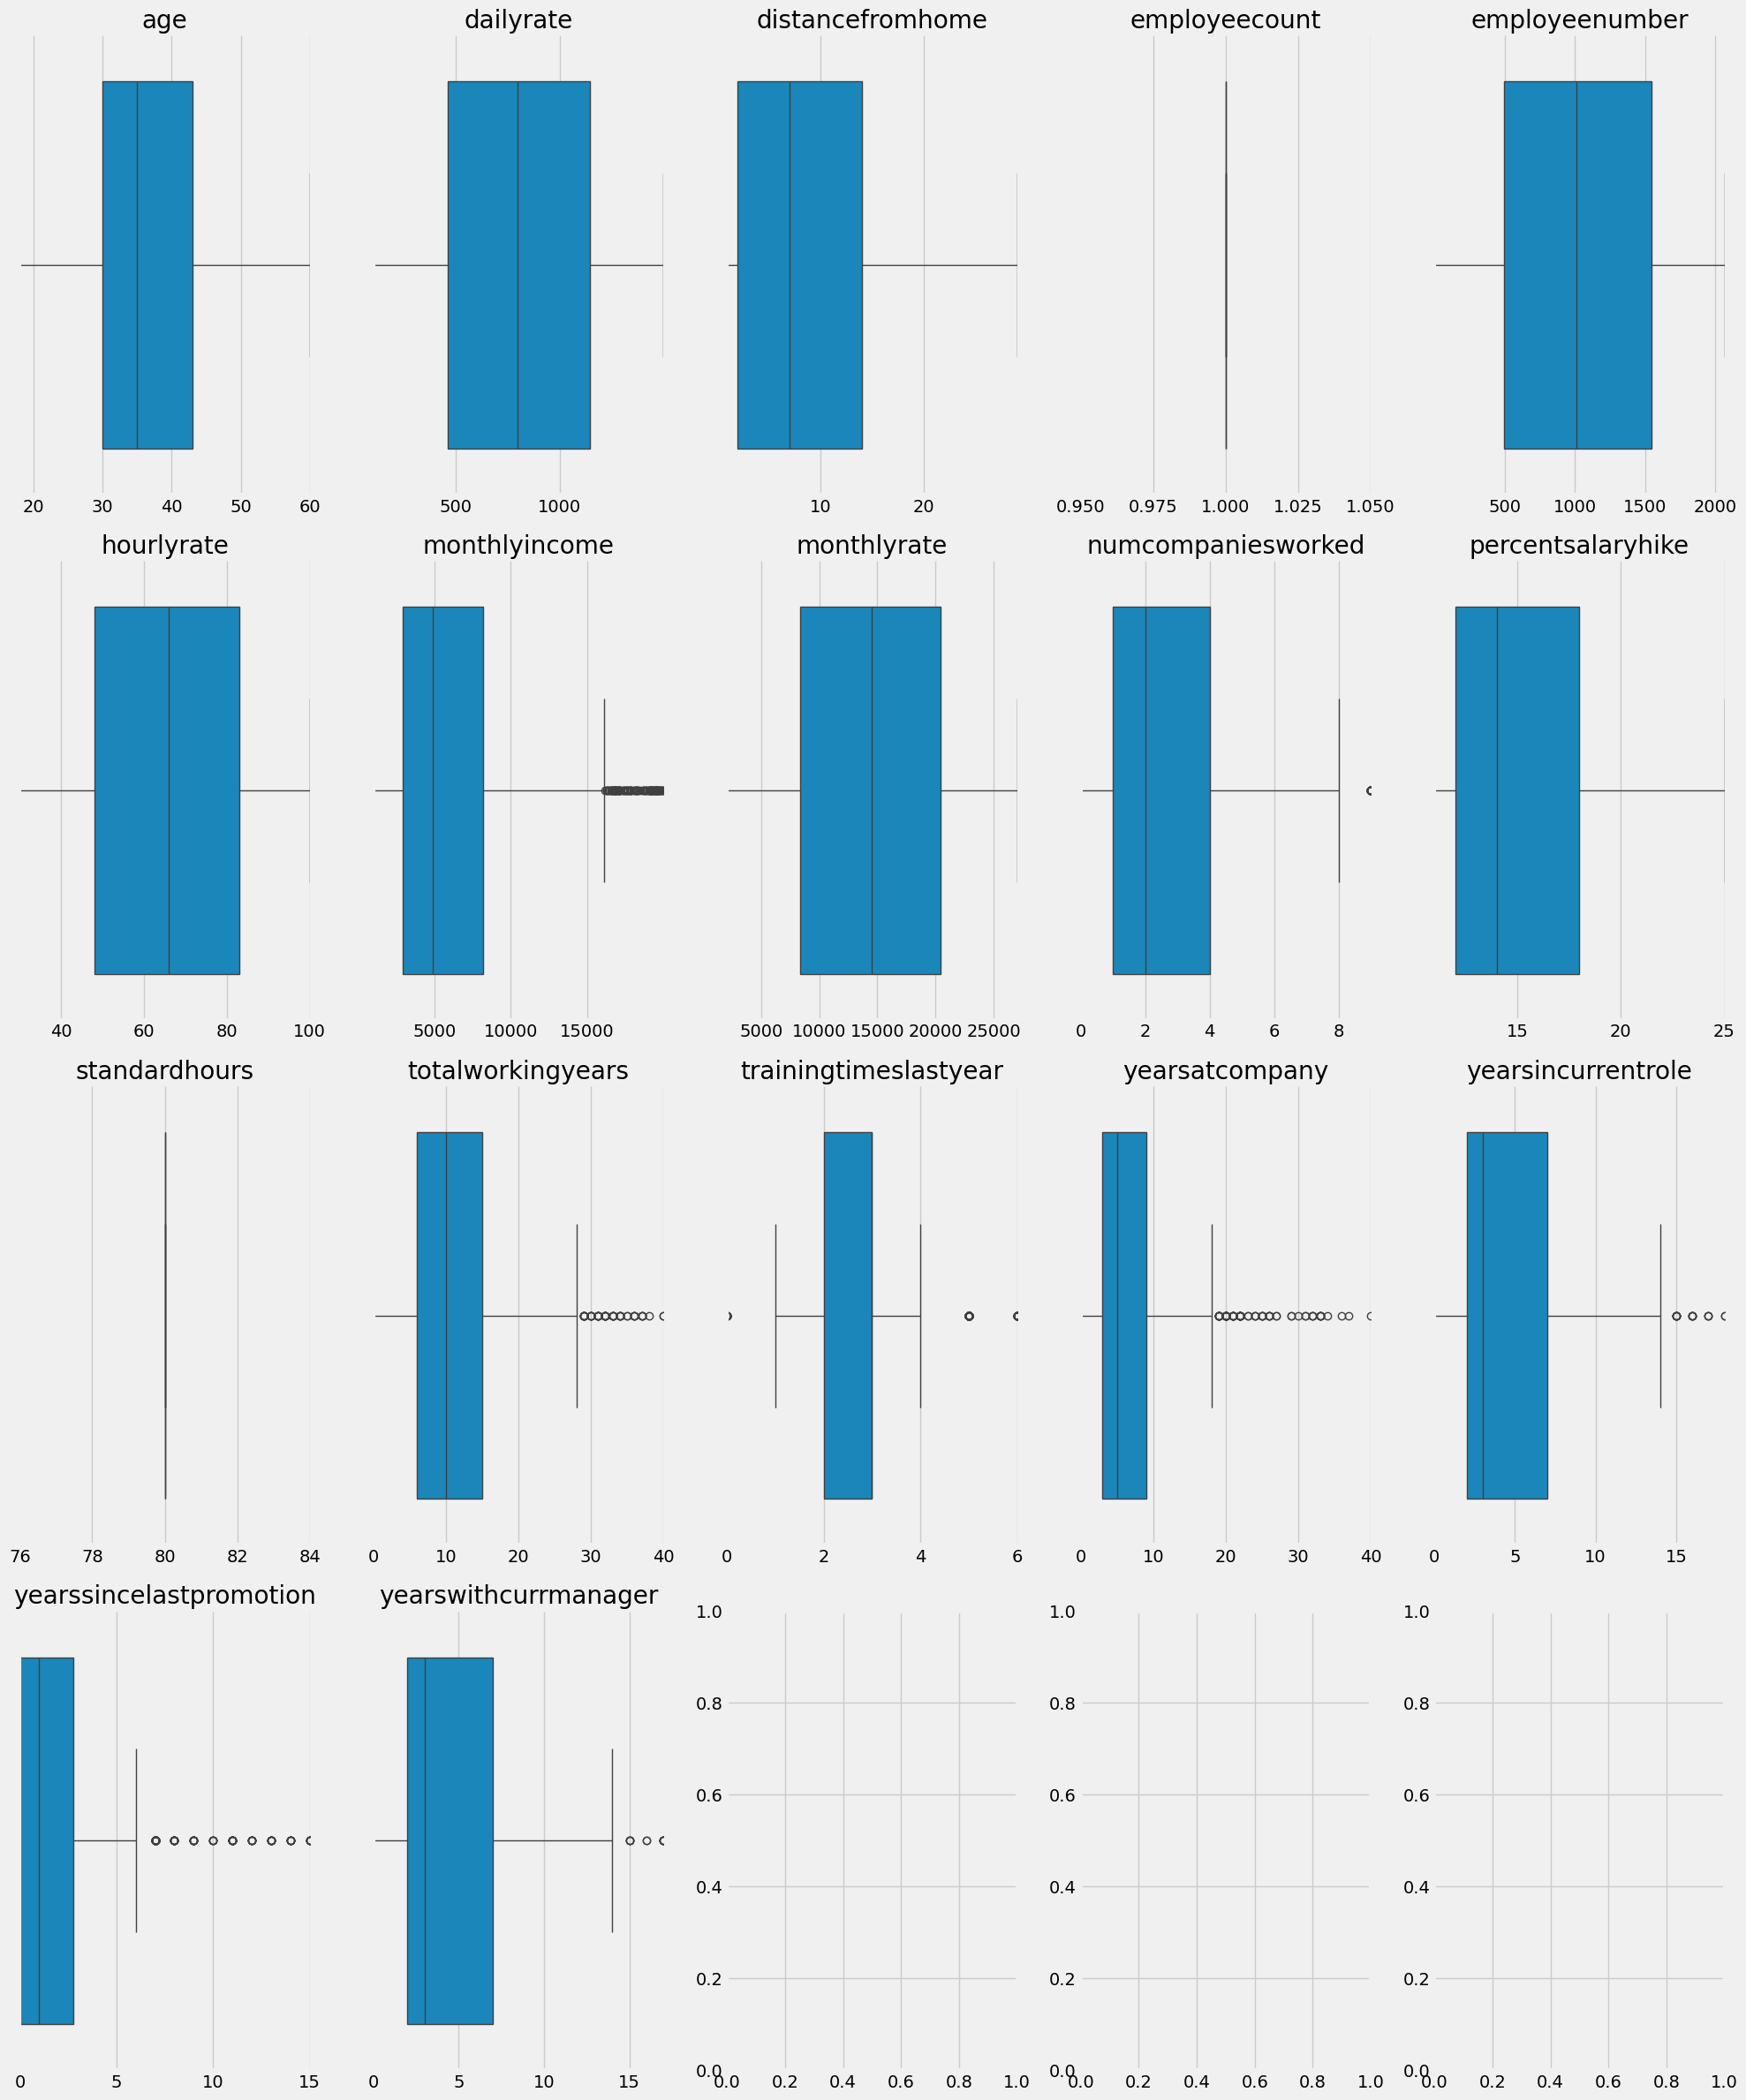

In [20]:

# Calculate the number of rows and columns for the subplot grid
num_cols = 5  # Number of columns in the grid
num_rows = 4  # Number of rows in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 24))
axes = axes.flatten()

for i, col in enumerate(enumerical_col):
    sns.boxplot(x=edata[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_xlim(zipped_values[i][0],zipped_values[i][1])


# Remove spines for cleaner look
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### Handling outliers

**Exercise 4: Use lower bound as 25% and upper bound as 75% to handle the outliers [0.5 Mark]**

In [21]:
quantiles = edata[enumerical_col].quantile([0.25, 0.75])
quantiles

,age,dailyrate,distancefromhome,employeecount,employeenumber,hourlyrate,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,standardhours,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0.25,30.0,461.00,2.0,1.0,496.25,48.0,2914.75,8387.50,1.0,12.0,80.0,6.0,2.0,3.0,2.0,0.00,2.0
0.75,43.0,1146.75,14.0,1.0,1548.50,83.0,8215.25,20456.25,4.0,18.0,80.0,15.0,3.0,9.0,7.0,2.75,7.0


In [10]:
# YOUR CODE HERE
quantiles = edata[enumerical_col].quantile([0.25, 0.75])

for col in enumerical_col:
    lower_bound = quantiles[col][0.25]
    upper_bound = quantiles[col][0.75]

    edata.loc[edata[col] < lower_bound, col] = lower_bound
    edata.loc[edata[col] > upper_bound, col] = upper_bound

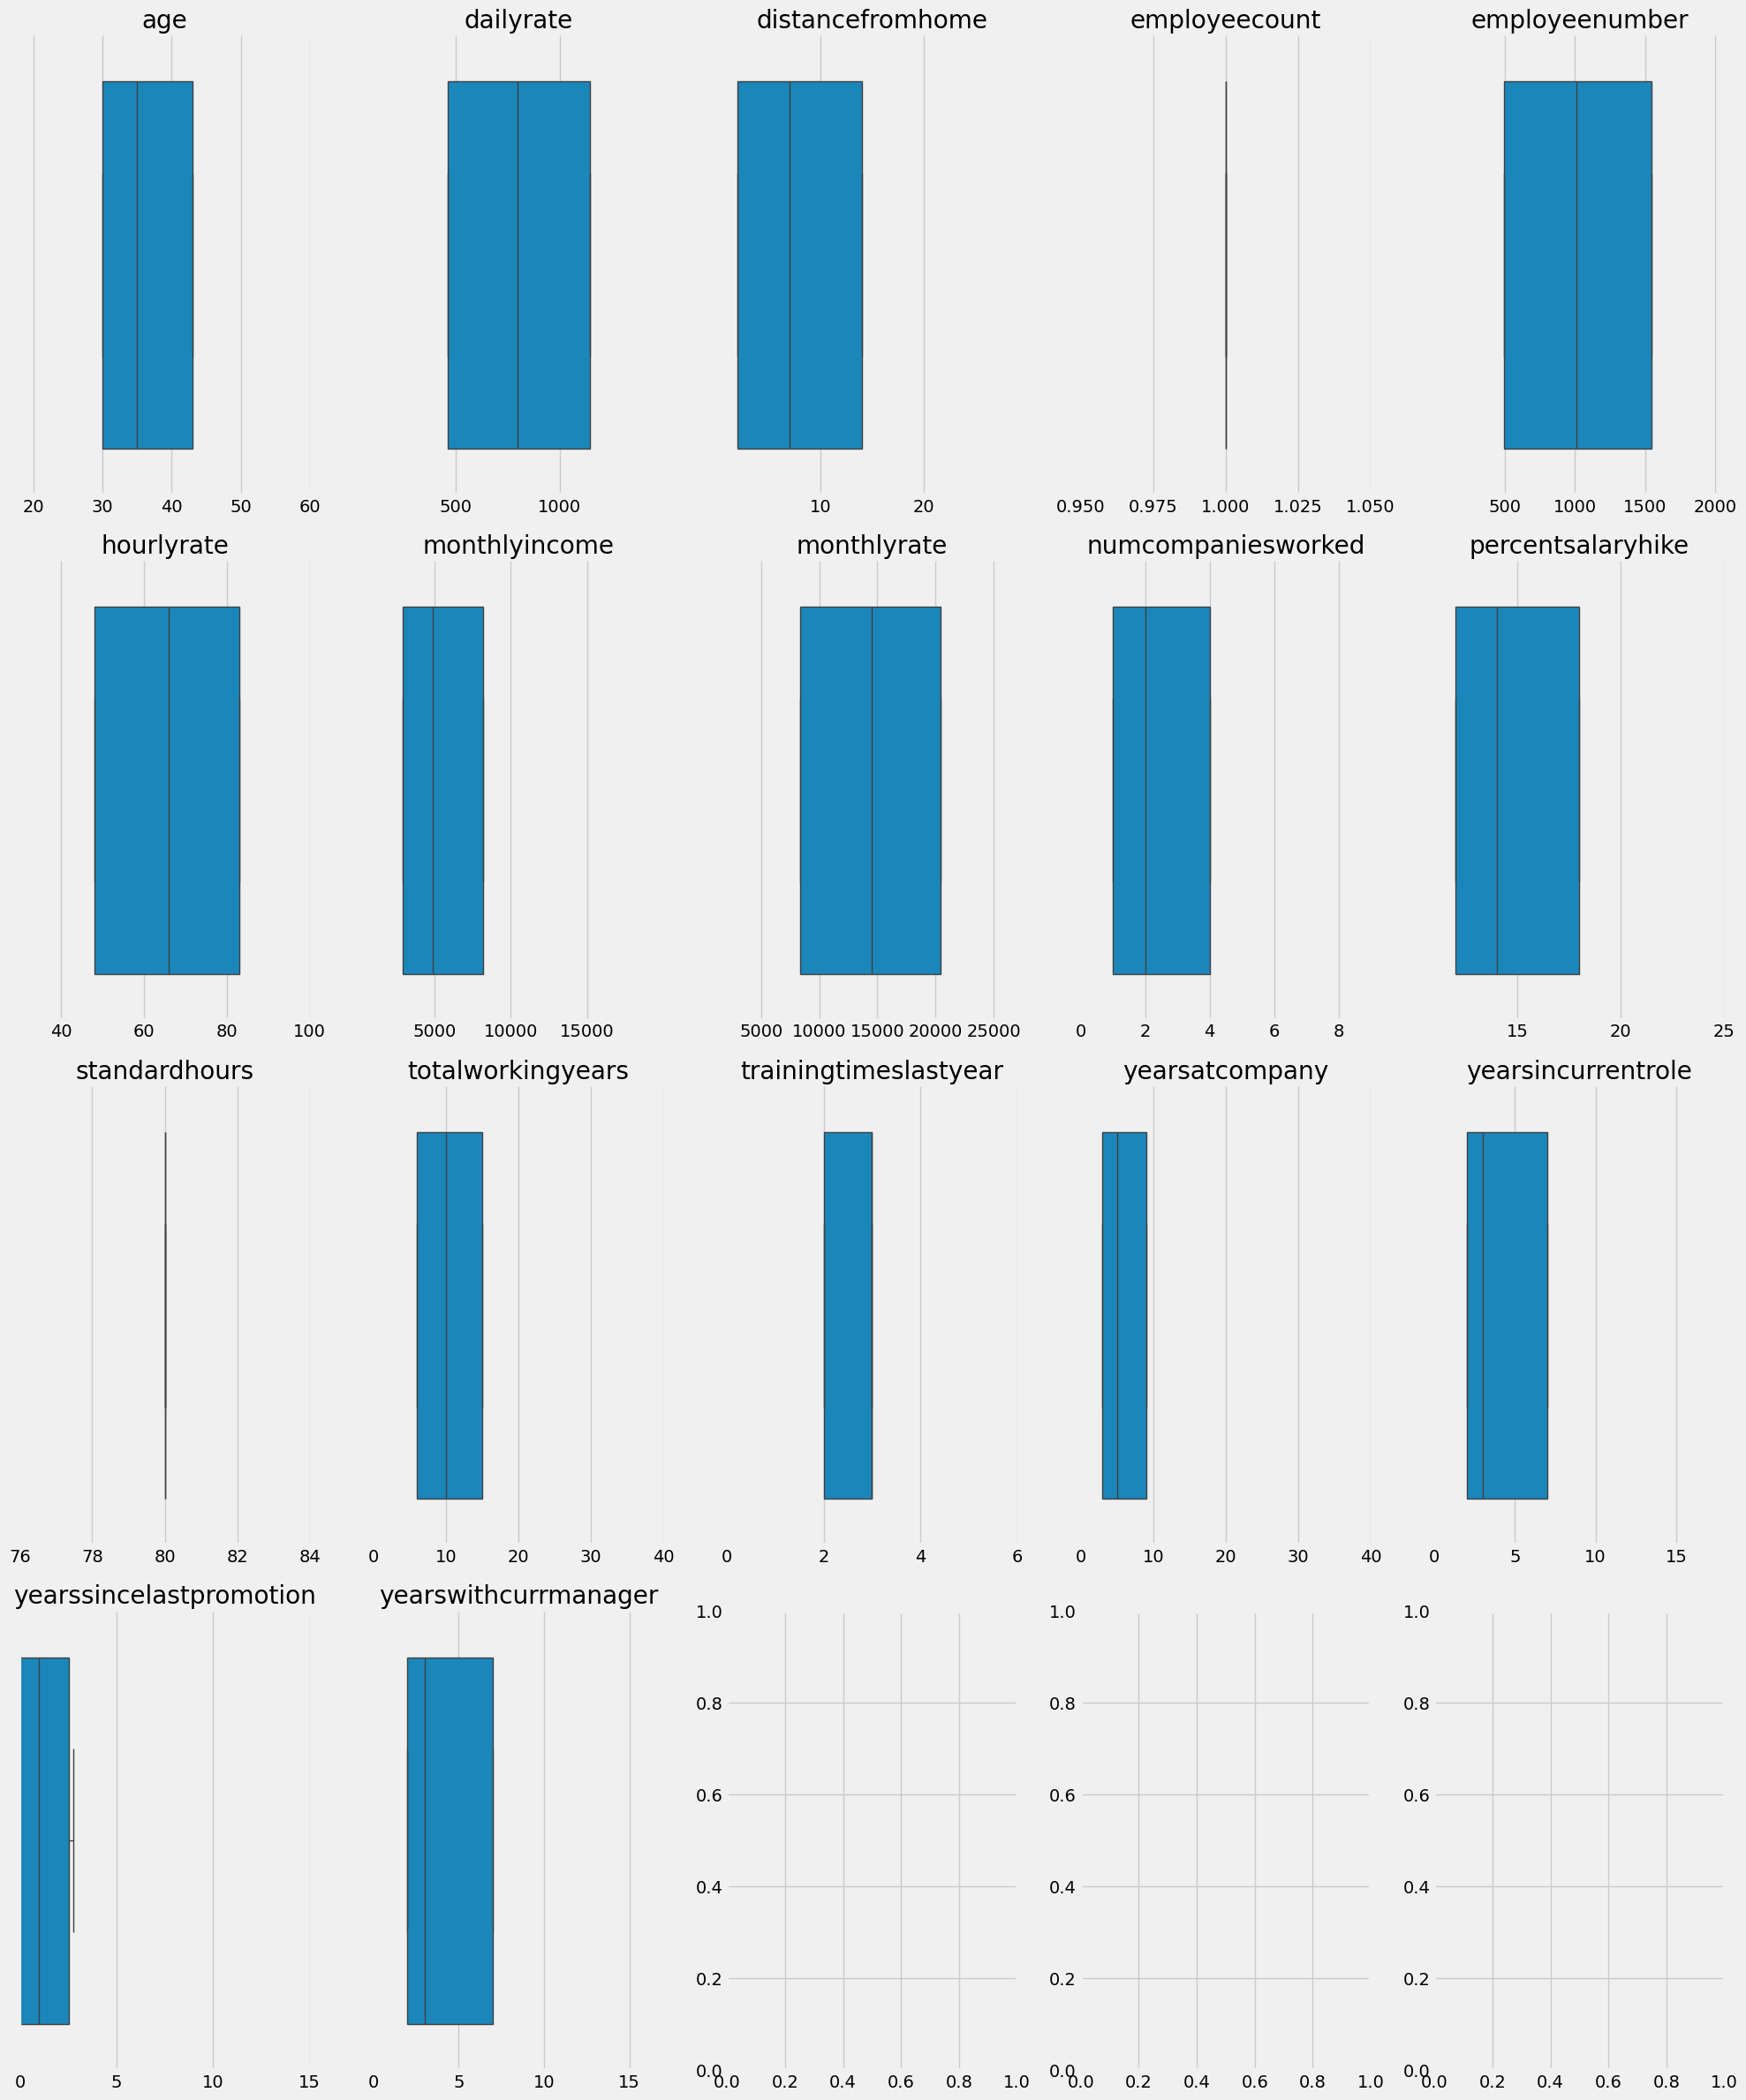

In [23]:
# Recheck for outliers
# YOUR CODE HERE
# Calculate the number of rows and columns for the subplot grid
num_cols = 5  # Number of columns in the grid
num_rows = 4  # Number of rows in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 24))
axes = axes.flatten()

for i, col in enumerate(enumerical_col):
    sns.boxplot(x=edata[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_xlim(zipped_values[i][0],zipped_values[i][1])


# Remove spines for cleaner look
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Feature Selection

In [11]:
# Conducting Feature Selection by various Filter Methods
#1. Correlation Method
f1_correlation = edata[enumerical_col + ['attrition']].corr()['attrition'].abs().sort_values(ascending=False)
print(f1_correlation)

attrition                  1.000000
yearsatcompany             0.177676
totalworkingyears          0.177190
age                        0.165979
monthlyincome              0.161451
yearsincurrentrole         0.160449
yearswithcurrmanager       0.130218
distancefromhome           0.098860
dailyrate                  0.064893
yearssincelastpromotion    0.059147
trainingtimeslastyear      0.039014
hourlyrate                 0.027401
monthlyrate                0.018437
employeenumber             0.011154
numcompaniesworked         0.006518
percentsalaryhike          0.002708
employeecount                   NaN
standardhours                   NaN
Name: attrition, dtype: float64


In [12]:
# 1. Separate features (X) and target (y)
X = edata[enumerical_col]
y = edata['attrition']

# 2. Perform ANOVA feature selection
f_statistic, p_values = f_classif(X, y)

# 3. Create a DataFrame to store results
f2_anova = pd.DataFrame({'Feature': enumerical_col, 'F-statistic': f_statistic, 'p-value': p_values})
f2_anova = f2_anova.sort_values(by='F-statistic', ascending=False)

print(f2_anova)

                    Feature  F-statistic       p-value
13           yearsatcompany    38.074278  9.374435e-10
11        totalworkingyears    37.859699  1.042809e-09
0                       age    33.088880  1.123490e-08
6             monthlyincome    31.260495  2.807358e-08
14       yearsincurrentrole    30.863359  3.426495e-08
16     yearswithcurrmanager    20.146931  7.880643e-06
2          distancefromhome    11.527904  7.086273e-04
1                 dailyrate     4.939437  2.644151e-02
15  yearssincelastpromotion     4.100490  4.309791e-02
12    trainingtimeslastyear     1.780551  1.823417e-01
5                hourlyrate     0.877616  3.490492e-01
7               monthlyrate     0.397181  5.286722e-01
4            employeenumber     0.145328  7.031103e-01
8        numcompaniesworked     0.049621  8.237623e-01
9         percentsalaryhike     0.008565  9.262784e-01
3             employeecount          NaN           NaN
10            standardhours          NaN           NaN


In [26]:
edata['standardhours'].unique()

array([80])

In [13]:
edata.drop(columns = ['employeenumber', 'employeecount','standardhours', 'over18'],inplace=True)

In [14]:
# Remove column dropped columns
ecategorical_col = ['businesstravel','department','educationfield','gender','jobrole','maritalstatus','overtime']
ordered_cat_col = ['education','environmentsatisfaction','jobinvolvement','joblevel','jobsatisfaction','relationshipsatisfaction','stockoptionlevel','worklifebalance','performancerating']
enumerical_col = ['age','dailyrate','distancefromhome','hourlyrate','monthlyincome','monthlyrate','numcompaniesworked','percentsalaryhike','totalworkingyears','trainingtimeslastyear','yearsatcompany','yearsincurrentrole','yearssincelastpromotion','yearswithcurrmanager']

### Target label imbalance

**Exercise 5: Check if there is an imbalance in target label [0.5 Mark]**

**Hint:** Use value_counts()

In [29]:
# Count of unique values in Attrition column
# YOUR CODE HERE
attrition_counts = edata['attrition'].value_counts()

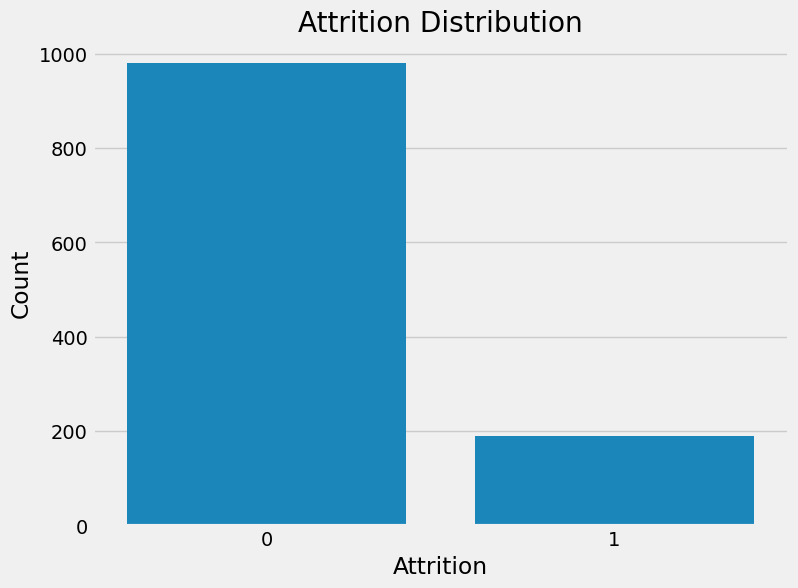

In [30]:
# Plot barplot to visualize balance/imbalance
# YOUR CODE HERE
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.barplot(x=attrition_counts.index, y=attrition_counts.values)
plt.title('Attrition Distribution')
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.show()

If there is any imbalance in the dataset then a few techniques can be utilised (optional):
1. SMOTE
2. Cross Validation
3. Regularizing the model's parameters

###Plot pairplot

**Exercise 6: Visualize the relationships between the predictor variables and the target variable using a pairplot [0.5 Mark]**

**Hint:** Use sns.pairplot

In [31]:
from sklearn.feature_selection import f_classif, SelectKBest


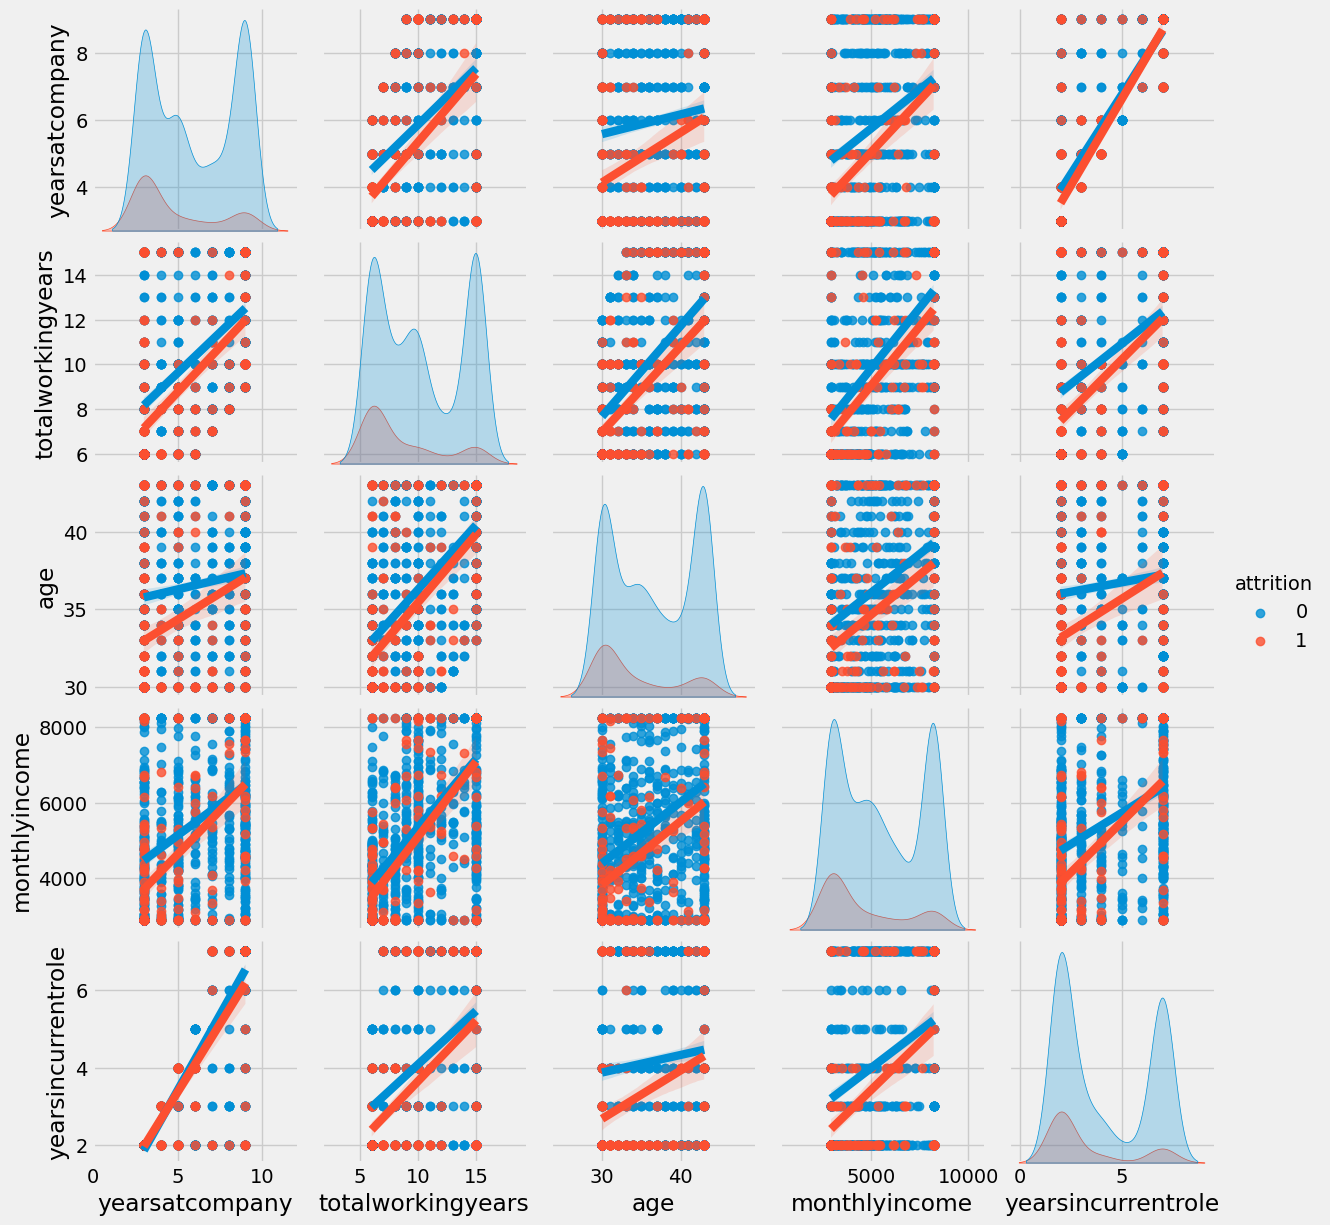

In [32]:
# Visualize a pairplot with relevant features
# YOUR CODE HERE
selected_columns = f1_correlation.index[:6]

# Create pair plot with 'Attrition' as hue
sns.pairplot(edata[selected_columns], hue='attrition',kind='reg')
plt.show()

### Explore Correlation

- Plotting the Heatmap

**Exercise 7: Visualize the correlation among IBM employee attrition numerical features using a heatmap [0.5 Mark]**

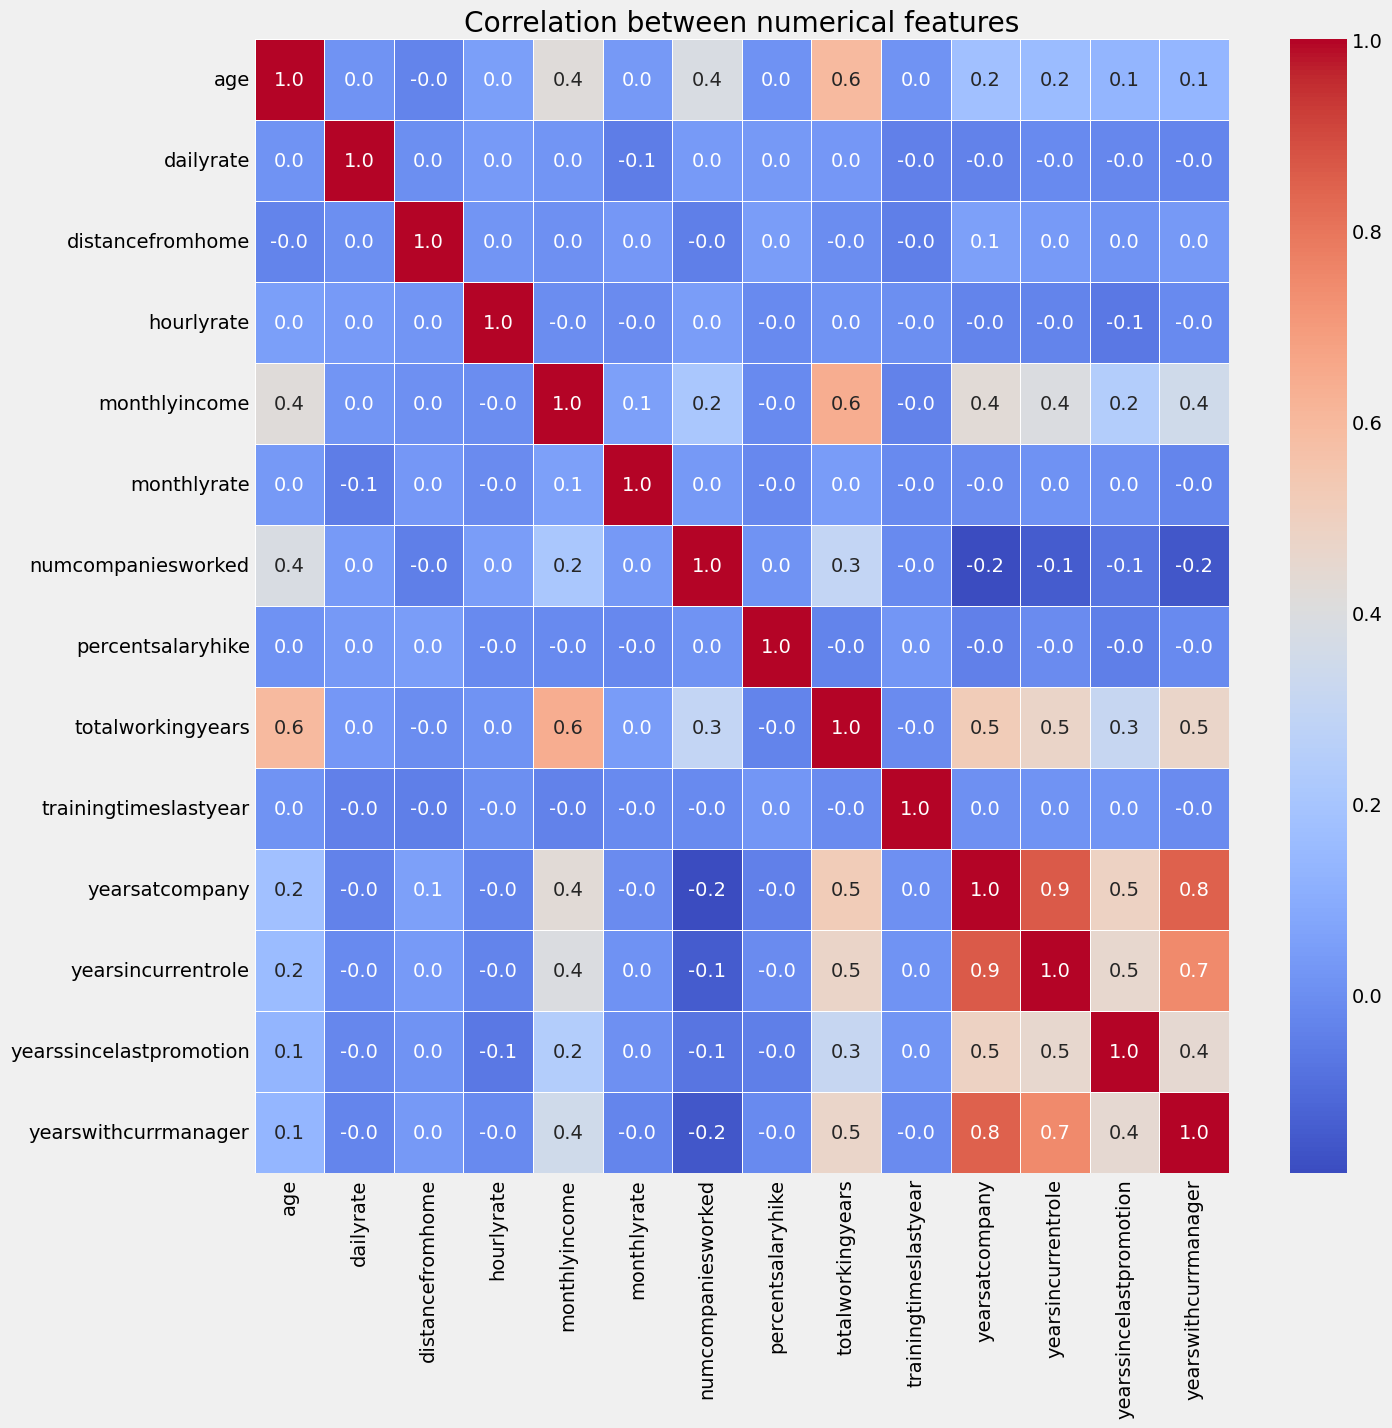

In [33]:
# Visualize heatmap
# YOUR CODE HERE
correlation_matrix = edata[enumerical_col].corr()

plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".1f",linewidths=0.5)
plt.title('Correlation between numerical features')
plt.show()

Comment on the observations made with the pairplot and heatmap

### Preparing the test feature space
* Remove outliers if any
* Handle the categorical feature if required
* Other processing steps can also be followed.

In the notebook, data processing is done separately for different models.
Considering the fact that different models may require data in different format and in turn different processes may be followed to process the data.

If the processing steps followed for the models are same, data processing can also be done once.

## Apply CatBoost

Catboost was released in 2017 by Yandex, showing, by their benchmark to be faster in prediction, better in accuracy, and easier to use for categorical data across a series of GBDT tasks. Additional capabilities of catboost include plotting feature interactions and object (row) importance.

[Here](https://catboost.ai/en/docs/) is the official documentation of CatBoost

### Data Processing for CatBoost

**Exercise 8: Data processing for CatBoost [1 Mark]**
* **Copy the dataframe that was created after removing the outliers**
* **Handle the categorical features if required**
* **Create target column and feature space**

**Hint:** Column containing the information on attrition will be the target column.

In [15]:
# Copy the data
# YOUR CODE HERE
ecatboost = edata.copy()

In [36]:
edata.head(2)

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,43,Travel_Rarely,556.0,Research & Development,14,2,Life Sciences,2,Female,83,2,2,Manufacturing Director,4,Married,5906.0,20456.25,1,No,13,3,4,2,10,2,2,9,7,2.75,7,0
1,34,Travel_Rarely,970.0,Research & Development,8,2,Medical,2,Female,83,3,2,Healthcare Representative,3,Single,6142.0,8387.50,3,No,12,3,4,0,10,2,3,5,2,2.75,3,0


In [37]:
ecatboost.head(2)

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,43,Travel_Rarely,556.0,Research & Development,14,2,Life Sciences,2,Female,83,2,2,Manufacturing Director,4,Married,5906.0,20456.25,1,No,13,3,4,2,10,2,2,9,7,2.75,7,0
1,34,Travel_Rarely,970.0,Research & Development,8,2,Medical,2,Female,83,3,2,Healthcare Representative,3,Single,6142.0,8387.50,3,No,12,3,4,0,10,2,3,5,2,2.75,3,0


In [16]:
# Target Column
# YOUR CODE HERE
y = ecatboost['attrition']

In [17]:
# Label Encoding
for col in ecategorical_col:
    ecatboost[col] = ecatboost[col].astype('category')
    ecatboost[col] = ecatboost[col].cat.codes

In [18]:
# Feature Space
# YOUR CODE HERE
X = pd.concat([ecatboost[enumerical_col], ecatboost[ordered_cat_col],ecatboost[ecategorical_col]], axis=1).copy()

In [19]:

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [20]:
# Get categorical features indices by selecting the features which are of type other than float
categorical_features_indices = np.where(X.dtypes != float)[0]            # np.where will give indices where the condition is True
categorical_features_indices

array([ 0,  2,  3,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29])

### Model Definition

**Exercise 9: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use CatBoostClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model. Refer [here](https://catboost.ai/en/docs/concepts/speed-up-training) to see some ways to speedup CatBoost training.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [ ]:
# Create training and validation sets
'''X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
X_test = etest'''

In [21]:
X_train, X_validation, y_train, y_validation = train_test_split(X_resampled, y_resampled, train_size=0.75, random_state=42)


In [22]:
# Create params dictionary
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
# Create Pool for training set
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)

# Create Pool for validation set
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)
print(validate_pool)

In [23]:
def model_metrics(model,validate_pool):

# Assuming 'model_cat' is your trained CatBoost model
# Assuming 'X_validation' and 'y_validation' are your validation data

    # 1. Predictions
    y_pred = model.predict(validate_pool) # Get predicted labels
    y_pred_proba = model.predict_proba(validate_pool)[:, 1]  # Get predicted probabilities for class 1

    # 2. Calculate Metrics
    roc_auc = roc_auc_score(validate_pool.get_label(), y_pred_proba)
    accuracy = accuracy_score(validate_pool.get_label(), y_pred)
    f1 = f1_score(validate_pool.get_label(), y_pred)

    precision = precision_score(validate_pool.get_label(), y_pred)

    # Calculate recall
    recall = recall_score(validate_pool.get_label(), y_pred)

    # 3. Print Results
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Optional: Display Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(validate_pool.get_label(), y_pred)
    print("Confusion Matrix:")
    print(cm)

In [24]:
# Create CatBoost model
# YOUR CODE HERE
# Create CatBoost model
model_cat1 = CatBoostClassifier(**params)

In [25]:
# Model training
# YOUR CODE HERE
model_cat1.fit(train_pool,
          eval_set=validate_pool,
          verbose=False);

In [26]:
# Create earlystop_params variable by updating 'od_type' and 'od_wait' in params
earlystop_params = params.copy()
earlystop_params.update({
                         'od_type': 'Iter',
                         'od_wait': 40
                         })

In [27]:
model_cat2 = CatBoostClassifier(**earlystop_params)

In [28]:
model_cat2.fit(train_pool,
          eval_set=validate_pool,
          verbose=False);

### Model performance

In [29]:
# Model performance on all sets
# YOUR CODE HERE
model_metrics(model_cat1,validate_pool)

ROC AUC: 0.9564
Accuracy: 0.8961
F1 Score: 0.8940
Precision: 0.9307
Recall: 0.8600
Confusion Matrix:
[[225  16]
 [ 35 215]]


In [30]:
model_metrics(model_cat2,validate_pool)

ROC AUC: 0.9473
Accuracy: 0.8839
F1 Score: 0.8810
Precision: 0.9214
Recall: 0.8440
Confusion Matrix:
[[223  18]
 [ 39 211]]


In [31]:
#Feature Importance
feature_importances = model_cat1.get_feature_importance(train_pool)
# Feature names
feature_names = X_train.columns

indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[indices]
sorted_feature_names = feature_names[indices]


# Show features in decreasing order based on their importances
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

yearssincelastpromotion: 7.177800970904659
stockoptionlevel: 6.470896971148296
businesstravel: 5.789196277255307
jobsatisfaction: 5.365983309720927
environmentsatisfaction: 5.098008195015702
overtime: 4.706278136164033
jobrole: 4.470735259654418
joblevel: 4.1315813997039115
jobinvolvement: 4.102235307861388
totalworkingyears: 4.036306359459719
hourlyrate: 3.8910077289702967
relationshipsatisfaction: 3.6142746085536146
yearswithcurrmanager: 3.5410592111099892
educationfield: 3.4031157246916277
worklifebalance: 3.28172882946495
percentsalaryhike: 3.24008843289243
yearsatcompany: 3.1566033726354226
monthlyincome: 2.8890324214666943
distancefromhome: 2.845271023247799
education: 2.8288371579306126
age: 2.733605437491936
trainingtimeslastyear: 2.592617483056883
yearsincurrentrole: 2.4538779169318143
dailyrate: 2.214229211534389
monthlyrate: 2.0206094150551586
maritalstatus: 1.3667378992840542
numcompaniesworked: 1.168235445768618
department: 1.0226084936776585
gender: 0.3310218450190014
per

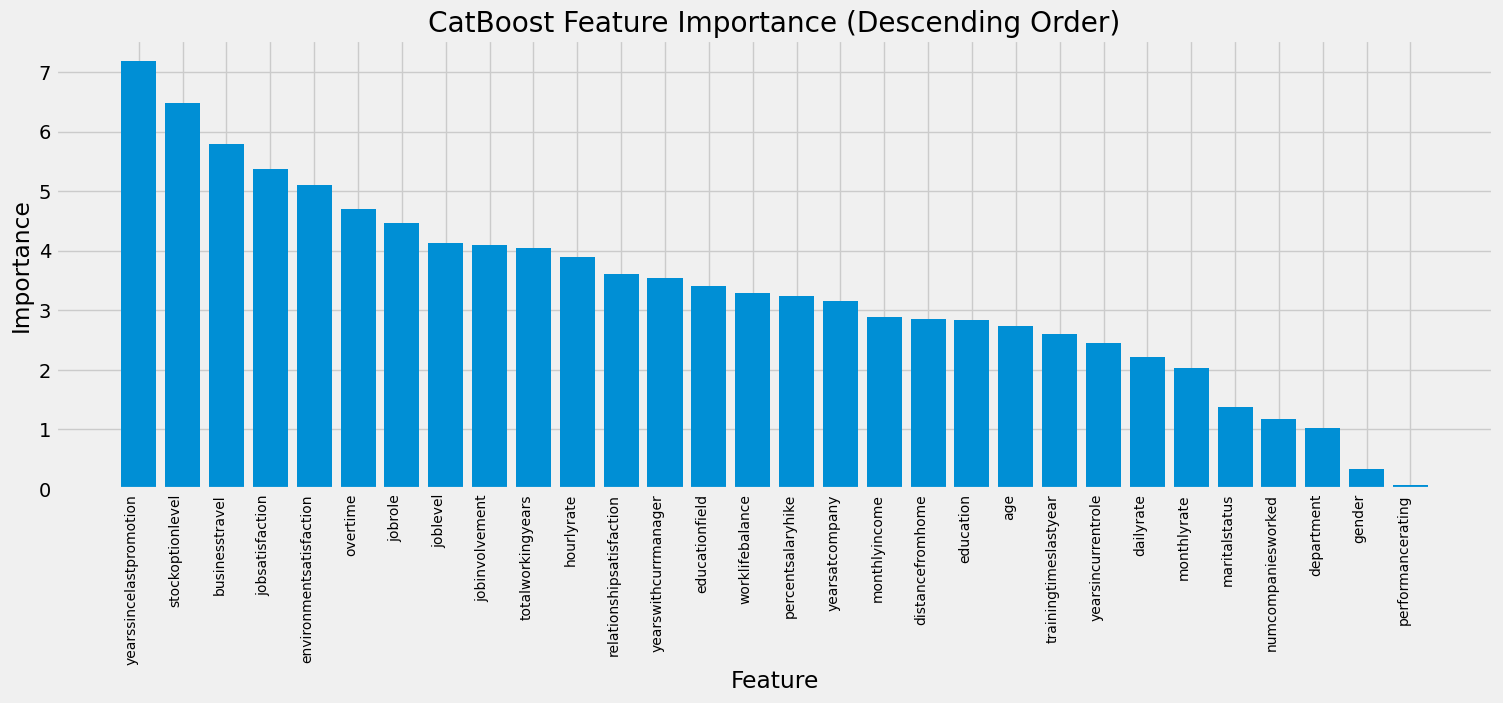

In [32]:
# Show bar plot for feature importance

plt.figure(figsize=(16, 8))  # Increase figure width for better spacing

plt.bar(sorted_feature_names, sorted_feature_importances)
plt.xlabel("Feature Number")
plt.ylabel("Importance")
plt.title("CatBoost Feature Importance (Descending Order)")
plt.xticks(rotation=90, ha='right', fontsize=10)  # Rotate, align right, and adjust font size

plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("CatBoost Feature Importance (Descending Order)")

# Adjust layout to prevent overlapping labels
plt.tight_layout(pad=3.0)  # Increase padding to avoid overlap

plt.show()

## Apply XGBoost

XGBoost is a workhorse gradient boosted decision tree algorithm. Its been around since 2014 and has come to dominate the Kaggle and data science community. XGB introduced gradient boosting where new models are fit to the residuals of prior models and then added together, using a gradient descent algorithm to minimize the loss.

Read [here](https://xgboost.readthedocs.io/en/stable/parameter.html) on XGBoost parameters.

Refer [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) for the official documentation of XGBoost classifier.

### Data Processing for XGBoost


**Exercise 10: Data Processing for XGBoost [1 Mark]**
* **Copy the dataframe after the outliers were removed.**
* **Handle the categorical features if required**
* **Create target column and feature space**

In [33]:
# Copy dataframe
# YOUR CODE HERE
exgboost = edata.copy()

In [32]:
exgboost.head(2)

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,43,Travel_Rarely,556.0,Research & Development,14,2,Life Sciences,2,Female,83,2,2,Manufacturing Director,4,Married,5906.0,20456.25,1,No,13,3,4,2,10,2,2,9,7,2.75,7,0
1,34,Travel_Rarely,970.0,Research & Development,8,2,Medical,2,Female,83,3,2,Healthcare Representative,3,Single,6142.0,8387.50,3,No,12,3,4,0,10,2,3,5,2,2.75,3,0


**Hint:** Use pd.get_dummies

In [34]:
# Handling categorical features
# YOUR CODE HERE
exgboost = pd.get_dummies(exgboost, columns=ecategorical_col, drop_first=True)


In [ ]:
exgboost.head(2)

In [ ]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE

When creating the dummy variables, the name of attrition column was changed, rename to 'attrition' again.

**Hint:** Use .rename

In [ ]:
# Rename target column
# YOUR CODE HERE

In [35]:
# Feature Space
# YOUR CODE HERE
X2 = exgboost.drop('attrition', axis=1)

# Targer label
# YOUR CODE HERE
y2 = exgboost['attrition']


In [ ]:
X2.shape

In [ ]:
y2.shape

In [36]:
X_train2, X_validation2, y_train2, y_validation2 = train_test_split(X2, y2, train_size=0.75, random_state=42)

### Model Definition

**Exercise 11: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use XGBClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [37]:
# Create XGBoost classifier model
# YOUR CODE HERE
model_xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)


In [38]:
# Model training
# YOUR CODE HERE
model_xgb.fit(X_train2,y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [39]:
# Rebalancing the data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled2, y_resampled2 = smote.fit_resample(X2, y2)

In [40]:
X_train3, X_validation3, y_train3, y_validation3 = train_test_split(X_resampled2, y_resampled2, train_size=0.75, random_state=42)

In [41]:
model_xgb2 = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

In [42]:
model_xgb2.fit(X_train3,y_train3)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Model Performance

In [43]:
# Model performance on all sets
# YOUR CODE HERE
def evaluate_performance(model, X_train, y_train, X_validation, y_validation, X_test, y_test=None):
    """
    Evaluates the performance of an XGBoost model on different datasets.

    Args:
        model: The trained XGBoost model.
        X_train: Training data features.
        y_train: Training data target.
        X_validation: Validation data features.
        y_validation: Validation data target.
        X_test: Test data features.
        y_test: Test data target (optional). If provided, evaluation metrics for the test set are also calculated.

    Returns:
        A dictionary containing evaluation metrics for each dataset.
    """

    results = {}

    # Evaluate on training set
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]  # Probabilities for class 1
    results['train'] = {
        'roc_auc': roc_auc_score(y_train, y_train_proba),
        'accuracy': accuracy_score(y_train, y_train_pred),
        'f1_score': f1_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'confusion_matrix': confusion_matrix(y_train, y_train_pred)
    }

    # Evaluate on validation set
    y_validation_pred = model.predict(X_validation)
    y_validation_proba = model.predict_proba(X_validation)[:, 1]
    results['validation'] = {
        'roc_auc': roc_auc_score(y_validation, y_validation_proba),
        'accuracy': accuracy_score(y_validation, y_validation_pred),
        'f1_score': f1_score(y_validation, y_validation_pred),
        'precision': precision_score(y_validation, y_validation_pred),
        'recall': recall_score(y_validation, y_validation_pred),
        'confusion_matrix': confusion_matrix(y_validation, y_validation_pred)
    }

    # Evaluate on test set if y_test is provided
    if y_test is not None:
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]
        results['test'] = {
            'roc_auc': roc_auc_score(y_test, y_test_proba),
            'accuracy': accuracy_score(y_test, y_test_pred),
            'f1_score': f1_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'confusion_matrix': confusion_matrix(y_test, y_test_pred)
        }

    return results

In [ ]:
results = evaluate_performance(model_xgb, X_train2, y_train2, X_validation2, y_validation2, X_test, y_test=None)  # Replace model_xgb, X_train, etc. with your actual variables

# Print the results
for dataset, metrics in results.items():
    print(f"Metrics for {dataset} set:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

In [ ]:
results_xgb = evaluate_performance(model_xgb2, X_train3, y_train3, X_validation3, y_validation3, X_test, y_test=None)  # Replace model_xgb, X_train, etc. with your actual variables

# Print the results
for dataset, metrics in results.items():
    print(f"Metrics for {dataset} set:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

## Apply LightGBM (Optional)

LightGBM is an open-source GBDT framework created by Microsoft as a fast and scalable alternative to XGB and GBM. By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).

To know more about LightGBM parameters, refer [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier).

### Feature Engineering for LightGBM

In [44]:
## Following the same procedure as followed in XGBoost

# Copy the dataframe
# YOUR CODE HERE
egbm = edata.copy()

# Handling categorical features
# YOUR CODE HERE
egbm = pd.get_dummies(egbm, columns=ecategorical_col, drop_first=True)

# Feature Space
# YOUR CODE HERE
X4 = egbm.drop('attrition', axis=1)

# Targer label
# YOUR CODE HERE
y4 = egbm['attrition']

In [45]:
# Rebalancing the data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled4, y_resampled4 = smote.fit_resample(X4, y4)

In [46]:
X_train4, X_validation4, y_train4, y_validation4 = train_test_split(X4, y4, train_size=0.75, random_state=42)

### Model Definition

**Hint:**
* Use LGBMClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [47]:
# Create LightGBM classifier model
# YOUR CODE HERE
model_lgbm = LGBMClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42,min_data_in_leaf=10, min_gain_to_split=0.01,force_row_wise=True)  # Adjust parameters as needed


In [ ]:
# Model training
# YOUR CODE HERE
model_lgbm.fit(X_train4, y_train4)


In [49]:
X_train5, X_validation5, y_train5, y_validation5 = train_test_split(X_resampled4, y_resampled4, train_size=0.75, random_state=42)

In [50]:
# Create LightGBM classifier model
# YOUR CODE HERE
model_lgbm2 = LGBMClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42,min_data_in_leaf=10, min_gain_to_split=0.01,force_row_wise=True)  # Adjust parameters as needed


In [ ]:
# Model training
# YOUR CODE HERE
model_lgbm2.fit(X_train5, y_train5)


### Model performance

In [ ]:
# Model performance on all sets
# YOUR CODE HERE
results = evaluate_performance(model_lgbm, X_train4, y_train4, X_validation4, y_validation4, X_test, y_test=None)  # Replace model_xgb, X_train, etc. with your actual variables

# Print the results
for dataset, metrics in results.items():
    print(f"Metrics for {dataset} set:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

In [ ]:
# Model performance on all sets
# YOUR CODE HERE
results_final = evaluate_performance(model_lgbm2, X_train5, y_train5, X_validation5, y_validation5, X_test, y_test=None)  # Replace model_xgb, X_train, etc. with your actual variables

# Print the results
for dataset, metrics in results.items():
    print(f"Metrics for {dataset} set:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")

In [52]:
# Apply HyperOpt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Define objective functions for each model
def objective_catboost(params):
    model = CatBoostClassifier(**params,
                               loss_function='Logloss',
                               eval_metric='Accuracy',
                               random_seed=42,
                               logging_level='Silent',
                               #use_best_model=True
                               )

    model.fit(X_train, y_train,
            eval_set=(X_validation, y_validation),
            cat_features=categorical_features_indices,
            verbose=False)
    y_pred = model.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}


In [53]:
def objective_xgboost(params):
    model = XGBClassifier(**params,
                            #objective = 'binary:logistic',
                            #eval_metric = 'logloss',
                            #use_label_encoder=False
                            )

    model.fit(X_train3, y_train3,
              eval_set=[(X_validation3, y_validation3)],
              verbose=False)
    y_pred = model.predict(X_validation3)
    accuracy = accuracy_score(y_validation3, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}



In [54]:
def objective_lightgbm(params):
    model = LGBMClassifier(**params)
    model.fit(X_train5, y_train5,
              eval_set=[(X_validation5, y_validation5)])
    y_pred = model.predict(X_validation5)
    accuracy = accuracy_score(y_validation5, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}

In [55]:
# Define search spaces for each model
space_catboost = {
    'iterations': hp.choice('iterations', [100, 200, 300,500,750,1000]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'depth': hp.choice('depth', [4, 6, 8,10]),
    'l2_leaf_reg': hp.choice('l2_leaf_reg', [1, 3, 5, 7, 9]),
    # ... other CatBoost hyperparameters
}

space_xgboost = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300,500,750,1000]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9]),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
    # ... other XGBoost hyperparameters
}

space_lightgbm = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300,500,750,1000]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'max_depth': hp.choice('max_depth', [3, 5, 7, 9]),
    'num_leaves': hp.choice('num_leaves', [31, 50, 100]),
    # ... other LightGBM hyperparameters
}


In [56]:
# Run Hyperopt for each model
trials = Trials()
best_catboost = fmin(fn=objective_catboost, space=space_catboost, algo=tpe.suggest, max_evals=50, trials=trials)

100%|██████████| 50/50 [23:37<00:00, 28.35s/trial, best loss: -0.9022403258655805]


In [ ]:
best_catboost

In [57]:
from sklearn.model_selection import RepeatedStratifiedKFold
from hyperopt import space_eval
# Rebuild models with tuned parameters
best_catboost_params = space_eval(space_catboost, best_catboost)

# Assuming X, y, categorical_features_indices are defined as before

# Define cross-validation parameters
n_splits = 5  # Number of folds
n_repeats = 3  # Number of repetitions
random_state = 42  # Random seed for reproducibility

# Create RepeatedStratifiedKFold object
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

print(rskf)

RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42)


In [60]:
# Initialize lists to store results
accuracies = []
roc_aucs = []
f1_scores = []

# Perform cross-validation
for train_index, val_index in rskf.split(X_resampled, y_resampled):
    # Split data into training and validation sets
    X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
    y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]


    best_catboost_model = CatBoostClassifier(**best_catboost_params,
                                            loss_function='Logloss',
                                            eval_metric='Accuracy',
                                            random_seed=42,
                                            #use_best_model=True
                                            )
    best_catboost_model.fit(X_train, y_train,
                eval_set=(X_validation, y_validation),
                cat_features=categorical_features_indices,
                verbose=False)

    # Make predictions on validation set
    y_pred = best_catboost_model.predict(X_val)
    y_pred_proba = best_catboost_model.predict_proba(X_val)[:, 1]

    # Calculate and store evaluation metrics
    accuracies.append(accuracy_score(y_val, y_pred))
    roc_aucs.append(roc_auc_score(y_val, y_pred_proba))
    f1_scores.append(f1_score(y_val, y_pred))

# Print average results and standard deviations
print(f"Average Accuracy: {np.mean(accuracies):.4f} (SD: {np.std(accuracies):.4f})")
print(f"Average ROC AUC: {np.mean(roc_aucs):.4f} (SD: {np.std(roc_aucs):.4f})")
print(f"Average F1 Score: {np.mean(f1_scores):.4f} (SD: {np.std(f1_scores):.4f})")


# Now you can use 'final_model' to make predictions on new data

Average Accuracy: 0.8869 (SD: 0.0121)
Average ROC AUC: 0.9525 (SD: 0.0089)
Average F1 Score: 0.8864 (SD: 0.0113)


In [61]:

# Train the final model on the entire dataset (optional)
catboost_model_final = CatBoostClassifier(**best_catboost_params,
                                            loss_function='Logloss',
                                            eval_metric='Accuracy',
                                            random_seed=42,
                                            #use_best_model=True
                                            )
catboost_model_final.fit(X_resampled, y_resampled,
            cat_features=categorical_features_indices,
            verbose=False)




In [62]:
trials = Trials()
best_xgboost = fmin(fn=objective_xgboost, space=space_xgboost, algo=tpe.suggest, max_evals=50, trials=trials)


100%|██████████| 50/50 [00:48<00:00,  1.03trial/s, best loss: -0.9368635437881874]


In [64]:
# Initialize lists to store results
accuracies_xg = []
roc_aucs_xg = []
f1_scores_xg = []
best_xgboost_params = space_eval(space_xgboost, best_xgboost)

# Perform cross-validation
for train_index, val_index in rskf.split(X_resampled2, y_resampled2):
    # Split data into training and validation sets
    X_train_xg, X_val_xg = X_resampled2.iloc[train_index], X_resampled2.iloc[val_index]
    y_train_xg, y_val_xg = y_resampled2.iloc[train_index], y_resampled2.iloc[val_index]


    best_xgboost_model = XGBClassifier(**best_xgboost_params,
                                   #objective = 'binary:logistic',
                                   #eval_metric = 'logloss',
                                   #use_label_encoder=False
                                   )
    best_xgboost_model.fit(X_train_xg, y_train_xg,
                eval_set=[(X_val_xg, y_val_xg)],
                verbose=False)

    # Make predictions on validation set
    y_pred_xg = best_xgboost_model.predict(X_val_xg)
    y_pred_proba_xg = best_xgboost_model.predict_proba(X_val_xg)[:, 1]

    # Calculate and store evaluation metrics
    accuracies_xg.append(accuracy_score(y_val_xg, y_pred_xg))
    roc_aucs_xg.append(roc_auc_score(y_val_xg, y_pred_proba_xg))
    f1_scores_xg.append(f1_score(y_val_xg, y_pred_xg))

# Print average results and standard deviations
print(f"Average Accuracy: {np.mean(accuracies_xg):.4f} (SD: {np.std(accuracies_xg):.4f})")
print(f"Average ROC AUC: {np.mean(roc_aucs_xg):.4f} (SD: {np.std(roc_aucs_xg):.4f})")
print(f"Average F1 Score: {np.mean(f1_scores_xg):.4f} (SD: {np.std(f1_scores_xg):.4f})")

Average Accuracy: 0.9278 (SD: 0.0118)
Average ROC AUC: 0.9736 (SD: 0.0054)
Average F1 Score: 0.9257 (SD: 0.0127)


In [65]:


xgboost_model_final = XGBClassifier(**best_xgboost_params,
                                   #objective = 'binary:logistic',
                                   #eval_metric = 'logloss',
                                   #use_label_encoder=False
                                   )
xgboost_model_final.fit(X_resampled2, y_resampled2,
              verbose=False)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7659348237470653, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09126206100334196,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
'''trials = Trials()
best_lightgbm = fmin(fn=objective_lightgbm, space=space_lightgbm, algo=tpe.suggest, max_evals=50, trials=trials)'''



In [ ]:
'''best_lightgbm_params = space_eval(space_lightgbm, best_lightgbm)
best_lightgbm_model = LGBMClassifier(**best_lightgbm_params)
best_lightgbm_model.fit(X_train5, y_train5,
              eval_set=[(X_validation5, y_validation5)],
              verbose=False)'''

## Results

**Exercise 12: Create a dataframe of XGBoost results and CatBoost results and display them [0.5 Mark]**

**Hint:** Use pd.DataFrame

In [ ]:
# Create a dataframe for computed metrics for different models
# YOUR CODE HERE


Reference reading:
1. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

## Kaggle Prediction

Load data from Kaggle competition site

In [120]:
# From the given Kaggle competition link, load the dataset 'hr_employee_attrition_test.csv'
# YOUR CODE HERE
etest = pd.read_csv('hr_employee_attrition_test.csv')

In [121]:
# From the dataset 'hr_employee_attrition_test.csv', drop columns ['id','employeenumber', 'employeecount', 'over18'] having single value
# YOUR CODE HERE
edf = etest.drop(columns=['id','employeenumber', 'employeecount','standardhours','over18'],axis=1)

In [122]:
edf = pd.get_dummies(edf, columns=ecategorical_col, drop_first=True)


In [123]:
edata_dtypes = X_resampled.dtypes

for col in edf.columns:
    if col in edata_dtypes:
        # Convert to the same data type as in edata
        edf[col] = edf[col].astype(edata_dtypes[col])


Predictions

In [102]:
# Get the predictions using your already trained CatBoost classifier model achieved in Exercise 9
# YOUR CODE HERE

y_pred_cat = catboost_model_final.predict(etest)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=2]=1144.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [124]:
# Get the predictions using your already trained XGBoost classifier model achieved in Exercise 11
# YOUR CODE HERE
y_pred_xg = xgboost_model_final.predict(edf)

Get the predictions using your trained Microsoft LightGBM model (Optional)

In [ ]:
# Get the predictions using your already trained Microsoft LightGBM classifier model
# achieved under the optional exercise 'Apply LightGBM (Optional)'
# YOUR CODE HERE

Save predictions to csv and submit under given Kaggle competiton link

In [125]:
# YOUR CODE HERE
save_df = pd.DataFrame({'id': etest['id'],
                        'label': y_pred_xg})
save_df.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [127]:
save_df.to_csv("predictions.csv", index=False)